# Install libraries

In [ ]:
pip install tensorflow-gpu==2.4.0 

     |████████████████████████████████| 394.7MB 40kB/s 
     |████████████████████████████████| 10.6MB 63.8MB/s 
     |████████████████████████████████| 471kB 55.6MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow-gpu 1.15.0
    Uninstalling tensorflow-gpu-1.15.0:
      Successfully uninstalled tensorflow-gpu-1.15.0


In [ ]:
pip install transformers

     |████████████████████████████████| 1.8MB 12.5MB/s 
     |████████████████████████████████| 890kB 58.0MB/s 
     |████████████████████████████████| 3.2MB 47.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=2fb02f21bcbb7c30bbb0721ece3e5f9f743a23a2b76b44a44bbd1948a782b282
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# Data loader

In [ ]:
# Maximum length of comment
max_len = 128 
# Dimension of embedding vector
embedding_dim = 25 
# Max feature
max_feature = 10000

In [ ]:
# Read data
import pandas as pd
from ast import literal_eval

data = pd.read_csv('drive/My Drive/CODE/SemVal/dataset/tsd_train.csv')
dev = pd.read_csv('drive/My Drive/CODE/SemVal/dataset/tsd_trial.csv')
test = pd.read_csv('drive/My Drive/CODE/SemVal/dataset/tsd_test_full.csv')

text_data = data['text'].values
spans = data['spans'].apply(literal_eval)
lbl = [1 if len(s) > 0 else 0 for s in spans]

text_data_test = test['text'].values
spans_test = test['spans'].apply(literal_eval)
test_id = test.index
lbl_test = [1 if len(s) > 0 else 0 for s in spans_test]

text_data_dev = dev['text'].values
spans_dev = dev['spans'].apply(literal_eval)
dev_id = dev.index
lbl_dev = [1 if len(s) > 0 else 0 for s in spans_dev]

In [ ]:
# Token level 

from nltk.tokenize import TweetTokenizer
import numpy as np
import spacy

tknzr2 = TweetTokenizer()

def custom_tokenizer(text_data):
    return tknzr2.tokenize(text_data)

def retrieve_word_from_span(lst_span, text):
    i = 0
    token = []
    a = 0

    word = []

    while (i < (len(lst_span) - 1)):
        if (lst_span[i] != (lst_span[i+1]-1)):
            token.append(lst_span[a:(i+1)])
            a = i + 1
        elif i == (len(lst_span) - 2):
            token.append(lst_span[a:i+2])

        i = i + 1

    for t in token:
        word.append(text[t[0]:(t[len(t)-1])+1])

    return word

def span_retrived(text_data, spans):
    token_labels = []

    for i in range(0, len(text_data)):
        token_labels.append(retrieve_word_from_span(spans[i], text_data[i]))
    
    return token_labels

def span_convert(text_data, spans):
    MAX_LEN = 0
    token_labels = []

    for i in range(0, len(text_data)):
        token_labels.append(retrieve_word_from_span(spans[i], text_data[i]))

    lst_seq = []
    for i in range(0, len(text_data)):
        # token = tknzr.tokenize(text_data[i])
        token = custom_tokenizer(text_data[i])
        if len(token) > MAX_LEN:
            MAX_LEN = len(token)
            
        seq = np.zeros(len(token), dtype=int)
        for j in range(0, len(token)):
            for t in token_labels[i]:
                # if token[j] in tknzr.tokenize(t):
                if token[j] in custom_tokenizer(t):
                    seq[j] = 1
        lst_seq.append(seq)     

    return (token_labels, lst_seq)

In [ ]:
from copy import deepcopy

# convert data
data['token'], data['seq'] = span_convert(text_data, spans)
dev['token'], dev['seq'] = span_convert(text_data_dev, spans_dev)
test['token'], test['seq'] = span_convert(text_data_test, spans_test)

train = deepcopy(data)
data = pd.concat([data, dev])

# Evaluation metric 

In [ ]:
# Evaluation metric

import sys
import os
import os.path
from scipy.stats import sem
import numpy as np
from ast import literal_eval

def f1(predictions, gold):
    """
    F1 (a.k.a. DICE) operating on two lists of offsets (e.g., character).
    >>> assert f1([0, 1, 4, 5], [0, 1, 6]) == 0.5714285714285714
    :param predictions: a list of predicted offsets
    :param gold: a list of offsets serving as the ground truth
    :return: a score between 0 and 1
    """
    if len(gold) == 0:
        return 1. if len(predictions) == 0 else 0.
    if len(predictions) == 0:
        return 0.
    predictions_set = set(predictions)
    gold_set = set(gold)
    nom = 2 * len(predictions_set.intersection(gold_set))
    denom = len(predictions_set) + len(gold_set)
    return float(nom)/float(denom)


def evaluate(pred, gold):
    """
    Based on https://github.com/felipebravom/EmoInt/blob/master/codalab/scoring_program/evaluation.py
    :param pred: file with predictions
    :param gold: file with ground truth
    :return:
    """
    # # read the predictions
    # pred_lines = pred.readlines()
    # # read the ground truth
    # gold_lines = gold.readlines()

    pred_lines = pred
    gold_lines = gold

    # only when the same number of lines exists
    if (len(pred_lines) == len(gold_lines)):
        data_dic = {}
        for n, line in enumerate(gold_lines):
            parts = line.split('\t')
            if len(parts) == 2:
                data_dic[int(parts[0])] = [literal_eval(parts[1])]
            else:
                raise ValueError('Format problem for gold line %d.', n)

        for n, line in enumerate(pred_lines):
            parts = line.split('\t')
            if len(parts) == 2:
                if int(parts[0]) in data_dic:
                    try:
                        data_dic[int(parts[0])].append(literal_eval(parts[1]))
                    except ValueError:
                        # Invalid predictions are replaced by a default value
                        data_dic[int(parts[0])].append([])
                else:
                    raise ValueError('Invalid text id for pred line %d.', n)
            else:
                raise ValueError('Format problem for pred line %d.', n)

        # lists storing gold and prediction scores
        scores = []
        for id in data_dic:
            if len(data_dic[id]) == 2:
                gold_spans = data_dic[id][0]
                pred_spans = data_dic[id][1]
                scores.append(f1(pred_spans, gold_spans))
            else:
                sys.exit('Repeated id in test data.')

        return (np.mean(scores), sem(scores))

# Data analysis 

In [ ]:
# Number of training data
print(len(train))

7939


In [ ]:
# Number of test data
print(len(test))

2000


In [ ]:
test

,spans,text,token,seq
0,"[84, 85, 86, 87, 88, 89, 90, 91, 133, 134, 135...",That's right. They are not normal. And I am st...,"[ABNORMAL, sexist rubbish]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[81, 82, 83, 84, 85, 86]","""Watch people die from taking away their healt...",[stupid],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,[],tens years ago i contacted the PDR and suggest...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,[],The parallels between the ANC and the Sicilian...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,[],Intel Community: ‘How can we work for a Presid...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
1995,"[4, 5, 6, 7, 8, 70, 71, 72, 73, 74, 75, 76, 77...",hey loser change your name to something more a...,"[loser, ignorant, loser]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1996,"[23, 24, 25, 26, 27]",And you are a complete moron who obviously doe...,[moron],"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1997,"[157, 158, 159, 160, 161, 162, 163, 164, 165, ...",Such vitriol from the left. Who would have th...,[hypocrites],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1998,[],It is now time for most of you to expand your ...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
# Show example of training data
train.tail(20)

,spans,text,token,seq
7919,"[49, 50, 51, 52, 53, 54]","Ah, so sad. It certainly does seem to bother t...",[trolls],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
7920,"[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 4...","Yes, let's end the insanity! No more trans pe...",[No more trans people! No more boys kissing bo...,"[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
7921,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",Such garbage logic by republicans which will b...,[Such garbage logic by republicans],"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
7922,"[33, 34, 35, 36, 37, 38, 39, 40, 41, 96, 97, 9...",aa the usual left wing attack of stupidity is ...,"[stupidity, crying that wont stop]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
7923,"[37, 38, 39, 40, 41]",The G&M doesn't need to repeat EVERY idiot thi...,[idiot],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
7924,"[177, 178, 179, 180, 181, 182, 183, 184, 185]","All this reality tv suspense, all this loud no...",[stupidity],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7925,"[15, 16, 17, 18, 19, 20]",Can't get over idiots like yourself who probab...,[idiots],"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7926,"[31, 32, 33, 34, 35, 36, 37, 38, 39, 45, 46, 4...",I only use the word haole when stupidity and a...,"[stupidity, arrogance]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ..."
7927,"[132, 133, 134, 135]",Pity Vegter doesn't apply the same rigour he n...,[dick],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7928,"[54, 55, 56, 57]","Anyone who voted for Hillary is blind, gullibl...",[fool],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"


In [ ]:
# counting word in spans for train 
len_span = train['token'].apply(len)

In [ ]:
# counting word in spans for test 
len_span_test = test['token'].apply(len)

In [ ]:
# Statistic spans by number of word in span for train 
len_span.value_counts(normalize=True, sort=True)

1     0.676534
2     0.200655
0     0.061091
3     0.043330
4     0.011588
5     0.003401
6     0.001512
7     0.001008
8     0.000504
11    0.000126
25    0.000126
9     0.000126
Name: token, dtype: float64

In [ ]:
# Statistic spans by number of word in span for test 
len_span_test.value_counts(normalize=True, sort=True)

1    0.7035
0    0.1970
2    0.0860
3    0.0080
4    0.0040
6    0.0010
7    0.0005
Name: token, dtype: float64

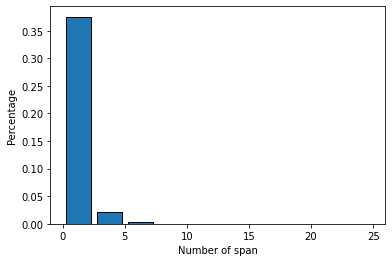

In [ ]:
# Distribution histogram plot
import matplotlib.pyplot as plt

import numpy as np
%matplotlib inline

fig, ax = plt.subplots()

ax.hist(len_span, density=True, edgecolor='k', rwidth=0.8)  # density=False would make counts

plt.ylabel('Percentage')
plt.xlabel('Number of span');

# Word embedding

In [ ]:
# Read embedding
word_dict = []
embeddings_index = {}
f = open('drive/My Drive/CODE/SemVal/embedding/glove.twitter.27B.25d.txt')
for line in f:
    values = line.split(' ')
    word = values[0] 
    word_dict.append(word)
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('GloVe data loaded')


GloVe data loaded


In [ ]:
words = word_dict
num_words = len(words)

# Dictionary word:index pair
# word is key and its value is corresponding index
word_to_index = {w : i + 2 for i, w in enumerate(words)}
word_to_index["UNK"] = 1
word_to_index["PAD"] = 0

# Dictionary lable:index pair
idx2word = {i: w for w, i in word_to_index.items()}

In [ ]:
# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_to_index.items():
    if i > max_feature:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

In [ ]:
 # mapping for token cases
case2Idx = {'1': 1, '0': 0}
caseEmbeddings = np.identity(len(case2Idx), dtype='float32')  # identity matrix used 

char2Idx = {"PADDING": 0, "UNKNOWN": 1}
for c in " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,-_()[]{}!?:;#'\"/\\%$`&=*+@^~|<>":
    char2Idx[c] = len(char2Idx)

# Data pre-processing 

In [ ]:
from sklearn.model_selection import train_test_split

y = data['seq']
X = data['text']

y_test = test['seq']
X_test = test['text']

In [ ]:
#train test
from sklearn.model_selection import train_test_split

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size = 0.1)

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer


from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.initializers import Constant
from nltk.corpus import stopwords
import re
import numpy as np

tknzr2 = TweetTokenizer()

def custom_tokenizer(text_data):
    text_data = text_data.lower()
    return tknzr2.tokenize(text_data)

def preprocess(text):
    text = text.lower()

    word_list = nltk.word_tokenize(text)
    lemma = WordNetLemmatizer()

    for w in word_list:
        w = lemma.lemmatize(w)

    new_text = ""
    for w in word_list:
        new_text = new_text + " " + w

    return new_text

def encoding(X, y, isTest = True):
    sentences = []
    
    for t in X:
        sentences.append(custom_tokenizer(t))

    X = []
    for s in sentences:
        sent = []
        for w in s:
            try:
                w = w.lower()
                sent.append(word_to_index[w])
            except:
                sent.append(word_to_index["UNK"])
        X.append(sent)
           
    X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word_to_index["PAD"])

    if isTest:
        y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=word_to_index["PAD"])
        y = to_categorical(y, num_classes=2)
    else:
        y = None

    return (X,y)


def decoding(text_data, encoding_text, prediction):
    test = [[idx2word[i] for i in row] for row in encoding_text]

    lst_token = []

    for t in range(0, len(test)):
        yy_pred = []
        for i in range(0, len(test[t])):
            if prediction[t][i] == 1:
                yy_pred.append(test[t][i])
        lst_token.append(yy_pred)

    lis_idx = []
    for i in range(0, len(text_data)):
        idx = []
        for t in lst_token[i]:
            index = text_data[i].find(t)
            idx.append(index)
            for j in range(1, len(t)):
                index = index + 1
                idx.append(index)
        lis_idx.append(idx)

    return lis_idx

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Using TensorFlow backend.


In [ ]:
X1, y1 = encoding(X_train, y_train)
X2, y2 = encoding(X_dev, y_dev)
X3, y3 = encoding(X_test, y_test)

In [ ]:
# Illustrating the data transforming 
x_t, y_t = encoding(X, y)

print(custom_tokenizer(X[7926]))
print(X[7926])
print(x_t[7926])

print(y[7926])

['i', 'only', 'use', 'the', 'word', 'haole', 'when', 'stupidity', 'and', 'arrogance', 'is', 'involved', 'and', 'not', 'all', 'the', 'time', '.', 'excluding', 'the', 'potus', 'of', 'course', '.']
I only use the word haole when stupidity and arrogance is involved and not all the time.  Excluding the POTUS of course.
[    12    216    718     15    894 724236     94  17046     28  48680
     34   6187     28     80     77     15    137      3  81507     15
  34058     41   1605      3      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0   

# Classification 

In [ ]:
import numpy as np 
import pandas as pd 
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('unitary/toxic-bert')

import torch

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

X_train_classify = text_data
y_train_classify = lbl

X_test_classify = text_data_test
y_test_classify = lbl_test


train_encodings = tokenizer(X_train_classify.tolist(), truncation=True, padding=True, max_length=max_len)
test_encodings = tokenizer(X_test_classify.tolist(), truncation=True, padding=True, max_length=max_len)

# train = pd.DataFrame({'text': train_encodings, 'labels': y_train_classify})
# # dev = pd.DataFrame({'text': dev_X, 'labels': dev_y})
# test = pd.DataFrame({'text': test_encodings, 'labels': y_test_classify})

# train = pd.concat([train, test])

train_dataset = BuildDataset(train_encodings, y_train_classify)
test_dataset = BuildDataset(test_encodings, y_test_classify)

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments, AutoModelForSequenceClassification


training_args = TrainingArguments(
    output_dir='drive/MyDrive/CODE/SemVal/results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
)

model = AutoModelForSequenceClassification.from_pretrained("unitary/toxic-bert")

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset             # evaluation dataset
)

trainer.train()

trainer.save_model('drive/MyDrive/CODE/SemVal/model/transformers2/')

In [ ]:
y_pred_classify = trainer.predict(test_dataset)

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score

y_pred = y_pred_classify.label_ids
y_true = y_test_classify

cf = confusion_matrix(y_true, y_pred)
print(cf)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

evaluation = recall_score(y_true, y_pred)
print("Recall: " + str(evaluation))